In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import math

from IPython.display import Image

# What is transformer architecture?

The transformer is a deep learning architecture that was developed by researchers at Google and is based on the multi-head attention mechanism, which was proposed in the 2017 paper "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)". Text is converted to numerical representations called tokens, and each token is converted into a vector via lookup from a word embedding table. At each layer, each token is then contextualized within the scope of the context window with other (unmasked) tokens via a parallel multi-head attention mechanism, allowing the signal for key tokens to be amplified and less important tokens to be diminished.

It consists of following components:
- Use of embeddings
  - Embeddings convert input tokens (words, subwords, or characters) into dense vectors so that neural network can process.
- Positional encoding
  - Positional encoding is added to embeddings so that the position of each token in a sequence can be identified.
- Attention
  - Attention allows the model to selectively focus on different parts of the input sequence when processing information.
  - The basic component of attention is Q (query), K (key), and V (value), and attention is to map a query and a set of key-value pairs to an output.
  - An attention score will be computed for each token relative to other tokens (see the following picture). High attention score means a token is strongly related to another token, vice versa.
  - For example, the following is the heatmap for the attention output of "The bank of the river is beautiful". The word "bank" has high attention score to the word "river" (0.068), demonstrating their strong links under this context.

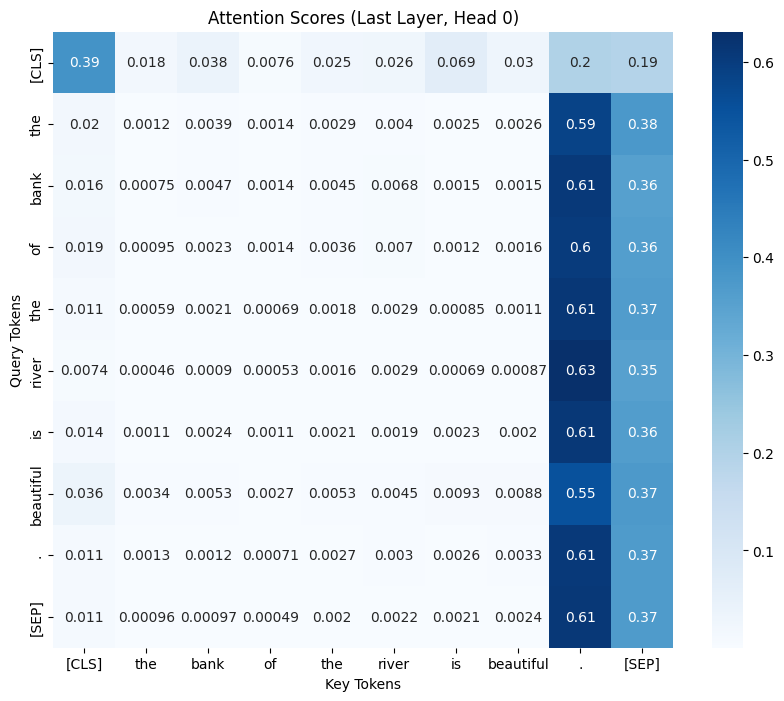

In [2]:
display(Image(filename="the_bank_of_the_river_is_beautiful.png"))

- Multi-head attention
  - Multi-head attention uses different heads to learn different attention patterns in parallel. Outputs from all heads are concatenated and transformed via a linear layer.
- Position-wise feed-forward networks
  - A fully connected feed-forward network that is applied to each token position in the sequence.
- Layer Normalization & Residual Connections
  - Residual connections help gradients flow and prevent vanishing gradients.
  - Layer normalization stabilizes training.
- Encoder and decoder stacks
  - The encoder processes the input data (e.g., a sentence) and converts it into a continuous representation (contextualized embeddings).
  - The decoder generates output sequences step by step (e.g., a translated sentence) with the contextual understanding from encoder.

A note on masking
- Encoder Self-Attention: Since whole input is known, no masking is required.
- Decoder Self-Attention: Masking is required in order to prevent "cheating" by restricting access to future tokens.
- Encoder-Decoder Attention: Masking is not required because decoder can freely access all of the (fixed) encoder output

Okay, here is the code without any optimization. There are three important variables:

- d_k: dimension of query and key vectors
- num_heads: number of attention heads, default is 8 in the paper
- d_model: overall hidden size of the transformer model and each token is represented as a vector of size d_model; d_model = d_k * num_heads

# Positional Encoding

The following section is only needed for sequential or spatial data. Typical classification and regression does not need the following.

In [3]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = 10000 ** (-torch.arange(0, d_model, 2, dtype=torch.float) / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

# Multi-head Attention

In [4]:
# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[0]

        # batch, seq_len, d_model -> batch, seq_len, num_heads, d_k
        # -1 is used for seq_len because the length of sequence can vary each time
        q = self.w_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2) 
        k = self.w_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.w_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # attention score
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.d_k ** 0.5
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)

        # contiguous is necessary after transpose 
        # following reshaping corresponds to the concatenation of outputs from multiple heads
        output = torch.matmul(attn, v).transpose(1, 2).contiguous().view(batch_size, -1, self.d_k * self.num_heads)
        return self.fc(output)

# Feed forward network

In [5]:
# Feed Forward Layer
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

# Encoder / Decoder Layer

In [6]:
# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)

        # it is necessary to have two different LayerNorm since mean/stdev are different
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, src_mask=None):
        attn_out = self.attention(x, x, x, mask=src_mask)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        return self.norm2(x + ff_out)


In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.encoder_decoder_attention = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, tgt_mask=None):
        self_attn_out = self.self_attention(x, x, x, mask=tgt_mask)
        x = self.norm1(x + self_attn_out)

        # Following makes sure the decoder's attention focuses on encoder words
        enc_dec_attn_out = self.encoder_decoder_attention(x, encoder_output, encoder_output)
        x = self.norm2(x + enc_dec_attn_out)
        
        ff_out = self.ff(x)
        return self.norm3(x + ff_out)

# Transformer Model (using all of the above)

In [8]:
# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_heads=4, num_layers=2, d_ff=256, max_len=5000):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, vocab_size)

    def generate_subsequent_mask(self, size):
        """Generate a triangular (causal) mask for the sequence."""
        mask = torch.tril(torch.ones(size, size)).bool()
        return mask

    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)
        x = self.pos_encoding(x)

        encoder_output = x
        for layer in self.encoder_layers:
            encoder_output = layer(encoder_output)

        # Generate causal mask for decoder self-attention
        seq_len = x.size(1)
        tgt_mask = self.generate_subsequent_mask(seq_len).to(x.device)  # (seq_len, seq_len)
        tgt_mask = tgt_mask.unsqueeze(0).expand(x.size(0), -1, -1)  # (batch, seq_len, seq_len)

        decoder_output = x
        for layer in self.decoder_layers:
            decoder_output = layer(decoder_output, encoder_output, tgt_mask=tgt_mask)

        return self.fc(decoder_output[:, -1, :])  # Predict next token only for the last position

# Let's put the model in use - next word prediction

In the following example, we will feed some example input and output from breaking up a complete sentence and see if the model can predict the next word from a given text.

In [9]:
# Dataset for Next Word Prediction
class NextWordPredictionDataset(Dataset):
    def __init__(self, sentences, vocab, seq_len):
        self.sentences = sentences
        self.vocab = vocab
        self.seq_len = seq_len
        self.pairs = self._prepare_pairs()

    def _prepare_pairs(self):
        pairs = []
        for sentence in self.sentences:
            words = sentence.split()
            for i in range(len(words) - self.seq_len):
                source = words[i:i + self.seq_len]
                target = words[i + self.seq_len]
                source_ids = [self.vocab[word] for word in source]
                target_id = self.vocab[target]
                pairs.append((torch.tensor(source_ids), torch.tensor(target_id)))
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

In [10]:
# Prediction Function
def predict_next_word(model, sentence, vocab, seq_len=3):
    model.eval()  # Set model to evaluation mode
    words = sentence.split()  # Tokenize the input sentence

    # Ensure the sentence has enough words to predict the next one
    if len(words) < seq_len:
        raise ValueError(f"Sentence must have at least {seq_len} words for prediction.")

    # Get the last `seq_len` words to predict the next word
    input_sequence = words[-seq_len:]
    input_ids = torch.tensor([vocab[word] for word in input_sequence]).unsqueeze(0)  # Add batch dimension

    # Get the prediction
    with torch.no_grad():  # No gradient needed for inference
        output = model(input_ids)
        predicted_id = torch.argmax(output, dim=-1).item()  # Get the predicted word ID

    # Find the predicted word from the vocab
    reverse_vocab = {v: k for k, v in vocab.items()}
    predicted_word = reverse_vocab.get(predicted_id, None)
    
    return predicted_word

In [11]:
# Example Data and Vocabulary
sentences = ["i am a good boy", "i like to play football", "he is a great teacher"]
vocab = {'i': 0, 'am': 1, 'a': 2, 'good': 3, 'boy': 4, 'like': 5, 'to': 6, 'play': 7, 'football': 8, 'he': 9, 'is': 10, 'great': 11, 'teacher': 12}
vocab_size = len(vocab)

# Prepare Dataset
seq_len = 3  # Number of words to predict the next word
dataset = NextWordPredictionDataset(sentences, vocab, seq_len)

# Initialize Model
model = TransformerModel(vocab_size)

# Define Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [12]:
# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for source, target in dataset:
        optimizer.zero_grad()

        # Forward pass
        output = model(source.unsqueeze(0))  # Add batch dimension

        # Compute loss
        loss = criterion(output, target.unsqueeze(0))  # Add batch dimension to target
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataset)}")

Epoch 1, Loss: 3.5104644695917764
Epoch 2, Loss: 0.7348930289347967
Epoch 3, Loss: 0.34177255630493164
Epoch 4, Loss: 0.11425354021290939
Epoch 5, Loss: 0.05339131752649943
Epoch 6, Loss: 0.03528535179793835
Epoch 7, Loss: 0.02659064655502637
Epoch 8, Loss: 0.021376486246784527
Epoch 9, Loss: 0.017980322086562712
Epoch 10, Loss: 0.015652438160032034


In [13]:
input_sentence = "i am a good"
predicted_word = predict_next_word(model, input_sentence, vocab, seq_len=3)
print(f"Prediction for the next word after '{input_sentence}': {predicted_word}")

Prediction for the next word after 'i am a good': boy


In [14]:
input_sentence = "he is a great"
predicted_word = predict_next_word(model, input_sentence, vocab, seq_len=3)
print(f"Prediction for the next word after '{input_sentence}': {predicted_word}")


Prediction for the next word after 'he is a great': teacher


In [15]:
input_sentence = "i like to"
predicted_word = predict_next_word(model, input_sentence, vocab, seq_len=3)
print(f"Prediction for the next word after '{input_sentence}': {predicted_word}")


Prediction for the next word after 'i like to': play


So the above code works!

# Supplement

Following is the code to generate the heatmap for an attention output.

In [16]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import numpy as np

def visualize_attention(sentence):
    # Load pre-trained BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
    
    # Tokenize input sentence
    inputs = tokenizer(sentence, return_tensors="pt")
    
    # Get model output with attention
    with torch.no_grad():
        outputs = model(**inputs)
    
    attentions = outputs.attentions  # Attention weights from all layers
    
    # Select the attention weights from the last layer (for simplicity, head 0)
    last_layer_attention = attentions[-1][0, 0]  # Shape: (seq_len, seq_len)
    
    # Convert token IDs back to words
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
    # Plot attention heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(last_layer_attention.numpy(), xticklabels=tokens, yticklabels=tokens, cmap="Blues", annot=True)
    plt.title("Attention Scores (Last Layer, Head 0)")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()

# Example sentence
# visualize_attention("The bank of the river is beautiful.")
